In [1]:
!pip install torchaudio librosa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 833.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [3]:
import torch
import torch.nn as nn
import numpy as np
import librosa

# Загрузка аудио (16 kHz)
audio, sr = librosa.load("/content/sample-3s (1).wav", sr=16000)
audio = torch.FloatTensor(audio).unsqueeze(0)  # [1, T]

# Мел-спектрограмма
n_fft = 1024
mel_spec = librosa.feature.melspectrogram(
    y=audio.numpy()[0], sr=sr, n_fft=n_fft, hop_length=256, n_mels=80
)
mel_spec = torch.FloatTensor(mel_spec).unsqueeze(0)  # [1, 80, T]

In [4]:
class VQEncoder(nn.Module):
    def __init__(self, input_dim=80, hidden_dim=128, num_embeddings=512):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(input_dim, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        )
        self.vq = nn.Embedding(num_embeddings, hidden_dim)
        self.codebook_size = num_embeddings

    def forward(self, x):
        x = self.encoder(x)  # [1, hidden_dim, T]
        x = x.permute(0, 2, 1)  # [1, T, hidden_dim]

        # Квантование
        distances = torch.cdist(x, self.vq.weight)  # [1, T, num_embeddings]
        tokens = torch.argmin(distances, dim=-1)  # [1, T]
        quantized = self.vq(tokens)  # [1, T, hidden_dim]

        return tokens, quantized.permute(0, 2, 1)

vq_encoder = VQEncoder()
tokens, quantized = vq_encoder(mel_spec)
print("Токены:", tokens.shape)  # [1, T]

Токены: torch.Size([1, 200])


In [5]:
class Decoder(nn.Module):
    def __init__(self, hidden_dim=128, output_dim=80):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, output_dim, kernel_size=3, padding=1)
        )

    def forward(self, x):
        return self.decoder(x)

decoder = Decoder()
reconstructed_mel = decoder(quantized)

# Griffin-Lim для преобразования в аудио (упрощённо)
audio_recon = librosa.griffinlim(
    reconstructed_mel.squeeze(0).detach().numpy(),
    n_fft=n_fft, hop_length=256
)

ValueError: could not broadcast input array from shape (513,200) into shape (80,200)

In [ ]:
librosa.output.write_wav("output.wav", audio_recon, sr)

TypeError: amplitude_to_db() got an unexpected keyword argument 'y_axis'

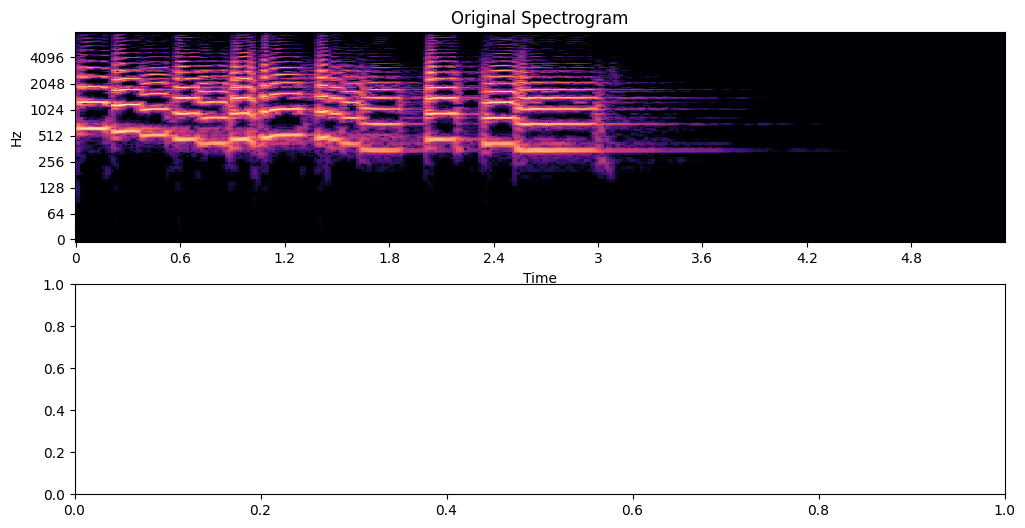

In [7]:
import torch
import torch.nn as nn
import numpy as np
import librosa
import soundfile as sf
import matplotlib.pyplot as plt

# 1. Загрузка и подготовка аудио
audio, sr = librosa.load(librosa.ex('trumpet'), sr=16000)
audio = torch.FloatTensor(audio).unsqueeze(0)  # [1, T]

# 2. Вычисление спектрограммы (STFT)
n_fft = 1024
hop_length = 256
stft = librosa.stft(audio.numpy()[0], n_fft=n_fft, hop_length=hop_length)
magnitude = np.abs(stft)  # Амплитудная спектрограмма
phase = np.angle(stft)    # Фазовая спектрограмма

# Преобразуем в PyTorch tensor
magnitude_tensor = torch.FloatTensor(magnitude).unsqueeze(0)  # [1, n_freq, T]

# 3. Энкодер с VQ-квантованием
class VQEncoder(nn.Module):
    def __init__(self, input_dim=513, hidden_dim=128, num_embeddings=512):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(input_dim, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        )
        self.vq = nn.Embedding(num_embeddings, hidden_dim)
        self.codebook_size = num_embeddings

    def forward(self, x):
        x = self.encoder(x)  # [1, hidden_dim, T]
        x = x.permute(0, 2, 1)  # [1, T, hidden_dim]

        # Квантование
        distances = torch.cdist(x, self.vq.weight)  # [1, T, num_embeddings]
        tokens = torch.argmin(distances, dim=-1)  # [1, T]
        quantized = self.vq(tokens)  # [1, T, hidden_dim]

        return tokens, quantized.permute(0, 2, 1)

vq_encoder = VQEncoder(input_dim=magnitude.shape[0])
tokens, quantized = vq_encoder(magnitude_tensor)

# 4. Декодер
class Decoder(nn.Module):
    def __init__(self, hidden_dim=128, output_dim=513):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, output_dim, kernel_size=3, padding=1)
        )

    def forward(self, x):
        return self.decoder(x)

decoder = Decoder(output_dim=magnitude.shape[0])
reconstructed_mag = decoder(quantized)

# 5. Восстановление аудио
def reconstruct_audio(magnitude, phase, n_fft, hop_length):
    """Восстановление аудио из амплитуды и фазы"""
    stft = magnitude * np.exp(1j * phase)
    return librosa.istft(stft, hop_length=hop_length, n_fft=n_fft)

# Используем оригинальную фазу для восстановления
audio_recon = reconstruct_audio(
    reconstructed_mag.squeeze(0).detach().numpy(),
    phase,
    n_fft=n_fft,
    hop_length=hop_length
)

# 6. Сохранение и визуализация
sf.write('original.wav', audio.numpy()[0], sr)
sf.write('reconstructed.wav', audio_recon, sr)

# Визуализация спектрограмм
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(magnitude, ref=np.max),
                         y_axis='log', x_axis='time', sr=sr, hop_length=hop_length)
plt.title('Original Spectrogram')

plt.subplot(2, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(reconstructed_mag.squeeze(0).detach().numpy(), y_axis='log', x_axis='time', sr=sr, hop_length=hop_length))
plt.title('Reconstructed Spectrogram')
plt.tight_layout()
plt.show()